# This notebook shows one very simple example of modulation field estimation with QE technique, from temperature data. 

Aim is to reconstruct $f(\hat n)$, where $$ T^{\rm CMB, \rm obs}(\hat n) = T^{\rm CMB}(\hat n)(1 + f(\hat n)) $$


In [1]:
%matplotlib inline
matplotlib.rcParams.update({'font.size': 12})
import sys
import os
import imp
from plancklens2018 import qresp
from plancklens2018 import qest
from plancklens2018 import utils
from plancklens2018.filt import filt_simple
import healpy as hp

Already up-to-date.


# We use Planck-like noise levels, transfer function etc parameters:

In [2]:
nlevt = 25.  # in uK-arcmin.
nlevp = 55.
nside = 2048 
transf = hp.gauss_beam(5. / 60 / 180 * np.pi, lmax=2048)

# Next we evaluate the analytical response of the TT-QE modulation estimator 

We will use this to normalize our estimates of $f$.

To do this, we define the parameters of our estimator and call *get_response*

('get_hl::spins: ', 0, 0, 0, 0)
('get_hl::spins: ', 0, 0, 0, 0)
('get_hl::spins: ', 0, 0, 0, 0)
('get_hl::spins: ', 0, 0, 0, 0)


Text(0,0.5,'$1 /R_L $')

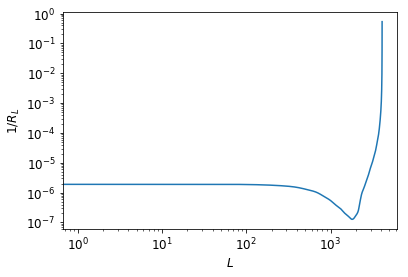

In [3]:
qe_key = 'ftt' # Modulation estimator from temperature.
aniso_source  = 'f'
lmax_ivf = 2048 # Max. CMB multipole used in QE.

cls_len = utils.camb_clfile('./inputs/cls/FFP10_wdipole_lensedCls.dat') # CMB spectra of the fiducial cosmo, from the repository
cls_weights = utils.camb_clfile('./inputs/cls/FFP10_wdipole_lensedCls.dat') # QE fiducial weights (here identical to lensed CMB spectra)

# Inverse-variance filters for idealised, full-sky maps:
ftl = 1. / (cls_len['tt'][:lmax_ivf + 1] + (nlevt / 60. /180. * np.pi) ** 2 / transf ** 2)
fel = 1. / (cls_len['ee'][:lmax_ivf + 1] + (nlevp / 60. /180. * np.pi) ** 2 / transf ** 2) 
fbl = 1. / (cls_len['bb'][:lmax_ivf + 1] + (nlevp / 60. /180. * np.pi) ** 2 / transf ** 2)
ftl[:100] *= 0. # We exclude the multipoles up to 100 in the analysis
fel[:100] *= 0.
fbl[:100] *= 0.

respG, respC = qresp.get_response_sepTP(qe_key, lmax_ivf, aniso_source, cls_weights, cls_len, {'t': ftl, 'e':fel, 'b':fbl})
#: This methods always give the gradient (G) and curl (C) responses, but in this case f is spin-0 hence has vanishing C mode (respC = 0)
qnorm = 1. / respG # For TT with optimal weighting, 1 / resp is not only the normalization but also the expected noise level
pl.loglog(qnorm)
pl.xlabel('$L$')
pl.ylabel('$1 /R_L $')

# Now we generate a modulation field, simulate (noise-free) CMB data and test reconstruction.

* We generate $f$
* We then build two simulation libraries (simple full-sky CMBS, reading maps from my NERSC scratch, and adding the transfer function). One will have no modulation field, the second will have $f$.
* Next we define filtering libraries, to inverse-variance filter the simulations. (Here, trivial isotropic filtering)
* With the filter libraries at hands, we then define the QE libraries which actually will compute the estimates of $f$ on the simulations.

In [4]:
flm = hp.synalm(np.ones(11) * 1e-4, new=True) 
# White large-scale modulation field, detectable according to noise levels above

In [5]:
class cmb_sims:
    """Simple sim. libraries of noise-free Planck FFP10 sims from my scratch. 
    
    """
    def __init__(self):
        pass
    def get_dat_tmap():
        alm = hp.read_alm('/global/cscratch1/sd/jcarron/jpipe/temp/lib_sims_cmb_lens_alm_from_ffp10_backup_wno_boost/sim_%04d_tlm.fits'%1000)
        hp.almxfl(alm, transf, inplace=True)               
        return hp.alm2map(alm, nside)
    
    def get_sim_tmap(self, idx):
        assert idx != 1000
        alm = hp.read_alm('/global/cscratch1/sd/jcarron/jpipe/temp/lib_sims_cmb_lens_alm_from_ffp10_backup_wno_boost/sim_%04d_tlm.fits'%idx)
        hp.almxfl(alm, transf, inplace=True)               
        return hp.alm2map(alm, nside)    
    def hashdict(self):
        return {'sims': 'noisefree ffp10 on JC scratch for Kareem TT mod example'}
    
class cmb_sims_wmod:
    """Same but modulated with field f. Inputs flm are its harmonic coefficients (healpy alm array).   
    
    """
    def __init__(self, flm):
        self.flm = flm
        
    def get_dat_tmap():
        ret = hp.alm2map(hp.read_alm('/global/cscratch1/sd/jcarron/jpipe/temp/lib_sims_cmb_lens_alm_from_ffp10_backup_wno_boost/sim_%04d_tlm.fits'%1000), 2048)
        ret *= (1. + hp.alm2map(self.flm, 2048))
        return hp.alm2map(hp.almxfl(hp.map2alm(ret, lmax=len(transf)-1, iter=0), transf), nside)    

    def get_sim_tmap(self, idx):
        assert idx != 1000
        ret = hp.alm2map(hp.read_alm('/global/cscratch1/sd/jcarron/jpipe/temp/lib_sims_cmb_lens_alm_from_ffp10_backup_wno_boost/sim_%04d_tlm.fits'%idx), 2048)
        ret *= (1. + hp.alm2map(self.flm, 2048))
        return hp.alm2map(hp.almxfl(hp.map2alm(ret, lmax=len(transf)-1, iter=0), transf), nside)    

    
    def hashdict(self):
        return {'sims': 'noisefree ffp10 with mod. on JC scratch for Kareem TT mod example wmod', 'mod_lm': utils.clhash(self.flm, dtype=np.complex64)}

sim_lib = cmb_sims()
ivfs = filt_simple.library_fullsky_sepTP('./temp/ivfs_ftt_test_forKareem', sim_lib, nside, transf, cls_len, ftl, fel, fbl, cache=False)
qlms_dd = qest.library_sepTP('./temp/qlmsdd_ftt_test_forKareem', ivfs, ivfs, cls_len['te'], 2048)

sim_lib_wm = cmb_sims_wmod(flm)
ivfs_wm = filt_simple.library_fullsky_sepTP('./temp/ivfs_wm_ftt_test_forKareem', sim_lib_wm, nside, transf, cls_len, ftl, fel, fbl, cache=False)
qlms_dd_wm = qest.library_sepTP('./temp/qlmsdd_wf_ftt_test_forKareem', ivfs_wm, ivfs_wm, cls_len['te'], 2048)


Caching sky fractions...
Caching sky fractions...


# Everything is ready, let's calculate!

* We can just call *get_sim_qlm* to get the QE estimates (this will call the simulations, filter them, and build the estimates), and normalize them properly. 
* We then compare reconstructed spectra, to input modulation spectrum, they should match quite well
* Of course plenty of complications in more realistic setups.

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


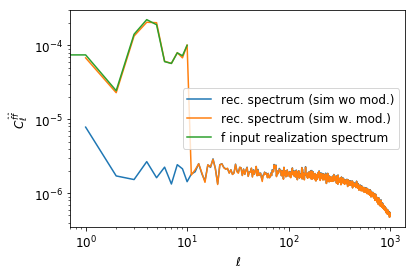

In [6]:
f1 = hp.almxfl(qlms_dd.get_sim_qlm('ftt', 0), qnorm)
f2 =  hp.almxfl(qlms_dd_wm.get_sim_qlm('ftt', 0), qnorm)

ell = np.arange(1, 1000)
pl.loglog(ell, hp.alm2cl(f1)[ell], label='rec. spectrum (sim wo mod.)')
pl.loglog(ell, hp.alm2cl(f2)[ell], label='rec. spectrum (sim w. mod.)')

pl.plot(np.arange(11), hp.alm2cl(flm), label='f input realization spectrum')
pl.xlabel(r'$\ell$')
pl.ylabel(r'$C^{\hat f \hat f}_\ell$')
pl.legend()